In [1]:
from src.pipelines.ingestion_pipeline import run_ingestion
from src.pipelines.preprocessing_pipeline import run_preprocessing
from src.pipelines.feature_pipeline import run_feature_engineering
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    roc_auc_score, accuracy_score, roc_curve,
    precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)


In [2]:
# Global results table
results_table = pd.DataFrame(columns=[
    'model_name', 'train_auc', 'test_auc',
    'best_threshold_acc', 'train_accuracy', 'test_accuracy',
    'best_threshold_f1', 'precision', 'sensitivity', 'f1_score'
])

def evaluate_model(model, model_name, X_train, y_train, X_test, y_test, results_df=None):
    # === Initialize results_df if not provided ===
    if results_df is None:
        results_df = results_table.copy()

    # === Ensure correct types for Keras compatibility ===
    X_train = np.asarray(X_train, dtype=np.float32)
    X_test = np.asarray(X_test, dtype=np.float32)
    y_train = np.asarray(y_train, dtype=np.float32)
    y_test = np.asarray(y_test, dtype=np.float32)

    # === Fit model ===
# === Fit model ===
    if model_name == 'NN_model':
        print('NN')
    else:
        model.fit(X_train, y_train)



    # === Predict probabilities ===
    if hasattr(model, "predict_proba"):
        y_train_pred = model.predict_proba(X_train)[:, 1]
        y_test_pred = model.predict_proba(X_test)[:, 1]
    else:
        y_train_pred = model.predict(X_train).flatten()
        y_test_pred = model.predict(X_test).flatten()

    # === AUC ===
    print('y_train')
    print(np.isnan(y_train).any())
    print('y_trai_pred')
    print(np.isnan(y_train_pred).any())
    train_auc = roc_auc_score(y_train, y_train_pred)

    test_auc = roc_auc_score(y_test, y_test_pred)

    # === Best threshold by Accuracy ===
    thresholds = np.linspace(0, 1, 250)
    train_accs = [accuracy_score(y_train, y_train_pred >= t) for t in thresholds]
    best_threshold_acc = thresholds[np.argmax(train_accs)]
    train_acc = max(train_accs)
    test_acc = accuracy_score(y_test, y_test_pred >= best_threshold_acc)

    # === Best threshold by F1 ===
    f1_scores = [f1_score(y_train, y_train_pred >= t) for t in thresholds]
    best_threshold_f1 = thresholds[np.argmax(f1_scores)]

    y_test_bin_f1 = (y_test_pred >= best_threshold_f1).astype(int)
    precision = precision_score(y_test, y_test_bin_f1)
    recall = recall_score(y_test, y_test_bin_f1)
    f1 = f1_score(y_test, y_test_bin_f1)

    # === Store results ===
    result_row = pd.DataFrame([{
        'model_name': model_name,
        'train_auc': round(train_auc, 4),
        'test_auc': round(test_auc, 4),
        'best_threshold_acc': round(best_threshold_acc, 4),
        'train_accuracy': round(train_acc, 4),
        'test_accuracy': round(test_acc, 4),
        'best_threshold_f1': round(best_threshold_f1, 4),
        'precision': round(precision, 4),
        'sensitivity': round(recall, 4),
        'f1_score': round(f1, 4)
    }])

    results_df = pd.concat([results_df, result_row], ignore_index=True)

    # === PRINT SUMMARY ===
    print(f"\n✅ Evaluation for {model_name}")
    print(f"AUC - Train: {train_auc:.4f}, Test: {test_auc:.4f}")
    print(f"Best Accuracy Threshold: {best_threshold_acc:.2f} | Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")
    print(f"Best F1 Threshold: {best_threshold_f1:.2f} | Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    # === ROC Curve ===
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr_train, tpr_train, label=f"Train ROC (AUC = {train_auc:.2f})")
    plt.plot(fpr_test, tpr_test, label=f"Test ROC (AUC = {test_auc:.2f})", linestyle='--')
    plt.plot([0, 1], [0, 1], linestyle=':', color='grey')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # === Confusion Matrix (best F1) ===
    cm = confusion_matrix(y_test, y_test_bin_f1)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name} (Threshold: {best_threshold_f1:.2f})")
    plt.tight_layout()
    plt.show()

    # === Distribution of Predicted Probabilities ===
    plt.figure(figsize=(6, 4))
    sns.histplot(y_train_pred[y_train == 0], bins=50, color='blue', label='Class 0', stat='density', kde=True)
    sns.histplot(y_train_pred[y_train == 1], bins=50, color='red', label='Class 1', stat='density', kde=True)
    plt.axvline(best_threshold_f1, color='black', linestyle='--', label=f"Best F1 Threshold = {best_threshold_f1:.2f}")
    plt.title(f"Train Set: Predicted Probability Distribution - {model_name}")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return results_df

In [3]:

# 1. Ingest raw data
raw_df = run_ingestion(data_dir='../Data', output_path='../Data/raw_data.parquet')
print(f"Ingested {len(raw_df)} rows of raw data.")


Ingested 500000 rows of raw data.


In [4]:

processed_df = run_preprocessing(
    raw_data_path='../Data/raw_data.parquet',
    output_path='../Data/processed_data.parquet'
)
print(f"Preprocessed {len(raw_df)} rows of raw data.")

Preprocessed 500000 rows of raw data.


In [5]:
processed_df.head()

,transaction_id,timestamp,user_id,merchant_id,amount,channel,currency,device,location,payment_method,...,distance_km,speed_kmph,amount/avg_amount,amount/sum_monthly_installments,amount/sum_monthly_expenses,country_u=t,country_m=t,countries_same,within_10pct,within_5pct
197951,TX197951,2022-01-08 16:48:00,U00001,M0245,32.24,online,EUR,Android,"{'lat': 54.710715, 'long': 15.368695}",mobile_payment,...,1994.074291,295.418413,0.163298,0.067491,0.132577,False,False,0,0.0,0.0
187979,TX187979,2022-01-12 16:23:00,U00001,M0332,4.29,in-store,EUR,Android,"{'lat': 58.897717, 'long': 30.25543}",debit_card,...,1016.169374,10.631611,0.23366,0.008981,0.017641,False,False,0,0.0,0.0
137034,TX137034,2022-01-18 10:40:00,U00001,M0331,67.0,in-store,EUR,iOS,"{'lat': 42.684202, 'long': 3.843828}",debit_card,...,2556.977104,18.491301,0.540715,0.140258,0.275516,False,False,0,0.0,0.0
401318,TX401318,2022-07-18 08:05:00,U00001,M0971,3.59,in-store,EUR,Web,"{'lat': 44.296089, 'long': 15.749937}",mobile_payment,...,976.612531,0.224952,3.663265,0.007515,0.014763,False,False,0,0.0,0.0
95555,TX095555,2022-08-09 12:30:00,U00001,M0598,22.94,online,EUR,iOS,"{'lat': 46.209657, 'long': 28.773734}",credit_card,...,1039.774561,1.952922,1.082586,0.048023,0.094333,False,False,0,0.0,0.0


In [6]:
print(list(processed_df.columns.values))

['transaction_id', 'timestamp', 'user_id', 'merchant_id', 'amount', 'channel', 'currency', 'device', 'location', 'payment_method', 'is_international', 'session_length_seconds', 'is_first_time_merchant', 'is_fraud', 'category', 'country_merchant', 'trust_score', 'number_of_alerts_last_6_months', 'avg_transaction_amount', 'account_age_months', 'has_fraud_history', 'age', 'sex', 'education', 'primary_source_of_income', 'sum_of_monthly_installments', 'sum_of_monthly_expenses', 'country_users', 'signup_date', 'risk_score', 'transaction_country', 'is_country_nan', 'country_merchant_distance_centroid', 'country_user_distance_centroid', 'country_merchant_distance_centroid_w', 'country_user_distance_centroid_w', 'Month_Year_EOM', 'Date', 'Year', 'hour', 'part_of_day', 'time_diff', 'time_diff_hours', 'latitude', 'longitude', 'lat_prev', 'lon_prev', 'time_prev', 'distance_km', 'speed_kmph', 'amount/avg_amount', 'amount/sum_monthly_installments', 'amount/sum_monthly_expenses', 'country_u=t', 'coun

In [7]:
prepare_kwargs = dict(
    to_drop=['transaction_id', 'user_id', 'currency', 'location'],
    to_think_but_drop=['signup_date','Month_Year_EOM','Date','Year','time_diff','time_prev',
                       'latitude','longitude','lat_prev','lon_prev'],
    to_categorize=['channel','device','payment_method','category','country_merchant','sex',
                   'education','primary_source_of_income','country_users','part_of_day','transaction_country'],
    cutoff="2023-07-01",
    target="is_fraud",
)

X_train, y_train, X_test, y_test = run_feature_engineering(
    processed_data_path="../data/processed_data.parquet",
    X_train_path="../data/X_train.parquet",
    X_test_path ="../data/X_test.parquet",
    y_train_path="../data/y_train.parquet",
    y_test_path ="../data/y_test.parquet",
    **prepare_kwargs
)

In [8]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import StratifiedKFold



In [9]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold

# Calculate scale_pos_weight
pos = np.sum(y_train == 1)
neg = np.sum(y_train == 0)
scale_pos_weight = neg / pos

# Define XGBoost model
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    learning_rate=0.1,
    max_depth=3,
    n_estimators=150,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,
    reg_alpha=0.1,
    reg_lambda=10,
    min_child_weight=1,
    scale_pos_weight=scale_pos_weight,
    verbosity=0,
    random_state=42
)

# Run cross-validation summary (optional)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_aucs, val_aucs = [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), 1):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    xgb_model.fit(X_tr, y_tr)
    tr_auc = roc_auc_score(y_tr, xgb_model.predict_proba(X_tr)[:, 1])
    val_auc = roc_auc_score(y_val, xgb_model.predict_proba(X_val)[:, 1])
    
    print(f"Fold {fold} - Train AUC: {tr_auc:.4f}, Validation AUC: {val_auc:.4f}")
    train_aucs.append(tr_auc)
    val_aucs.append(val_auc)

print("\nAverage Train AUC:", round(np.mean(train_aucs), 4))
print("Average Validation AUC:", round(np.mean(val_aucs), 4))


Fold 1 - Train AUC: 0.6109, Validation AUC: 0.5854
Fold 2 - Train AUC: 0.6114, Validation AUC: 0.5822
Fold 3 - Train AUC: 0.6112, Validation AUC: 0.5855
Fold 4 - Train AUC: 0.6105, Validation AUC: 0.5863
Fold 5 - Train AUC: 0.6119, Validation AUC: 0.5806

Average Train AUC: 0.6112
Average Validation AUC: 0.584


y_train
False
y_trai_pred
False

✅ Evaluation for XGBoost
AUC - Train: 0.6066, Test: 0.5815
Best Accuracy Threshold: 0.73 | Train Acc: 0.9156, Test Acc: 0.9143
Best F1 Threshold: 0.53 | Precision: 0.1115, Recall: 0.4108, F1: 0.1754


/var/folders/zw/vcgtv4pj2zj7729jp71l9gvw0000gn/T/ipykernel_67950/3494301503.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, result_row], ignore_index=True)


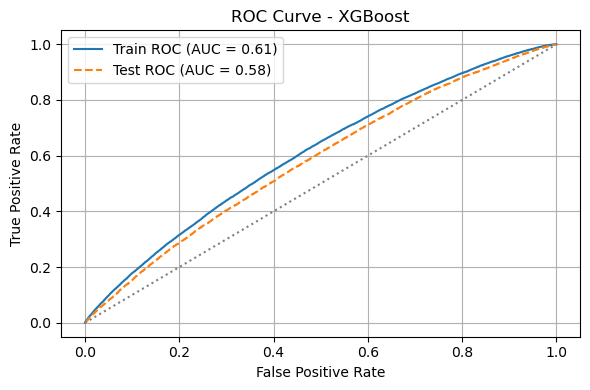

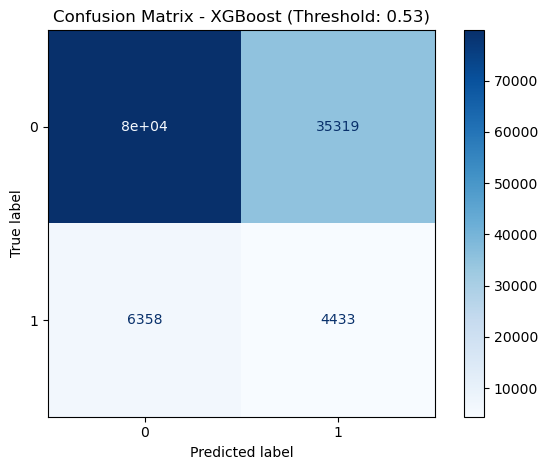

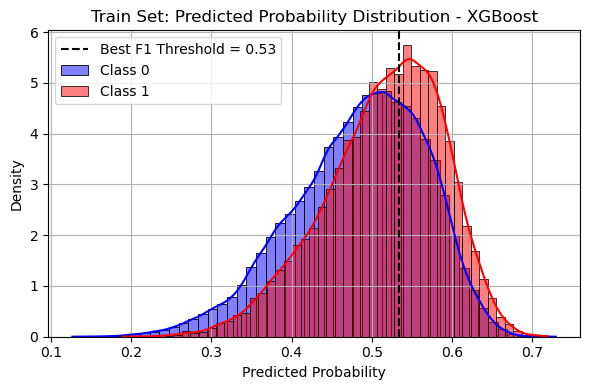

In [10]:
results_table = evaluate_model(xgb_model, "XGBoost", X_train, y_train, X_test, y_test, results_df=results_table)

In [11]:
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

# --- Calculate scale_pos_weight ---
pos = np.sum(y_train == 1)
neg = np.sum(y_train == 0)
scale_pos_weight = neg / pos

# --- Define LightGBM model ---
lgb_model = lgb.LGBMClassifier(
    objective='binary',
    learning_rate=0.1,
    max_depth=3,
    n_estimators=150,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=10,
    min_child_samples=20,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# --- 5-fold Cross-Validation (optional) ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_aucs, val_aucs = [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), 1):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    lgb_model.fit(X_tr, y_tr)
    tr_auc = roc_auc_score(y_tr, lgb_model.predict_proba(X_tr)[:, 1])
    val_auc = roc_auc_score(y_val, lgb_model.predict_proba(X_val)[:, 1])

    print(f"Fold {fold} - Train AUC: {tr_auc:.4f}, Validation AUC: {val_auc:.4f}")
    train_aucs.append(tr_auc)
    val_aucs.append(val_auc)

print("\nAverage Train AUC:", round(np.mean(train_aucs), 4))
print("Average Validation AUC:", round(np.mean(val_aucs), 4))


Fold 1 - Train AUC: 0.6117, Validation AUC: 0.5857
Fold 2 - Train AUC: 0.6118, Validation AUC: 0.5828
Fold 3 - Train AUC: 0.6118, Validation AUC: 0.5838
Fold 4 - Train AUC: 0.6109, Validation AUC: 0.5856
Fold 5 - Train AUC: 0.6112, Validation AUC: 0.5814

Average Train AUC: 0.6115
Average Validation AUC: 0.5838


/Users/tymoteusz/anaconda3/envs/stats_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/tymoteusz/anaconda3/envs/stats_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


y_train
False
y_trai_pred
False

✅ Evaluation for LGB
AUC - Train: 0.6066, Test: 0.5824
Best Accuracy Threshold: 0.72 | Train Acc: 0.9156, Test Acc: 0.9143
Best F1 Threshold: 0.52 | Precision: 0.1091, Recall: 0.4787, F1: 0.1777


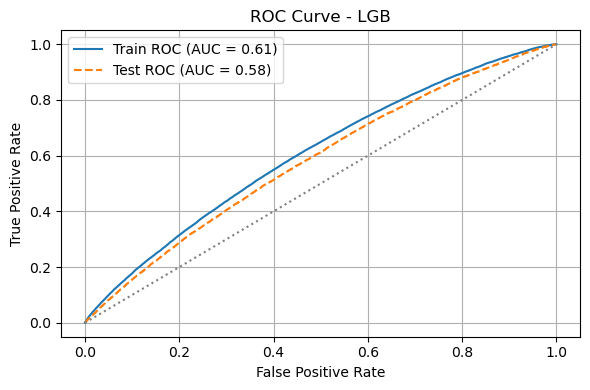

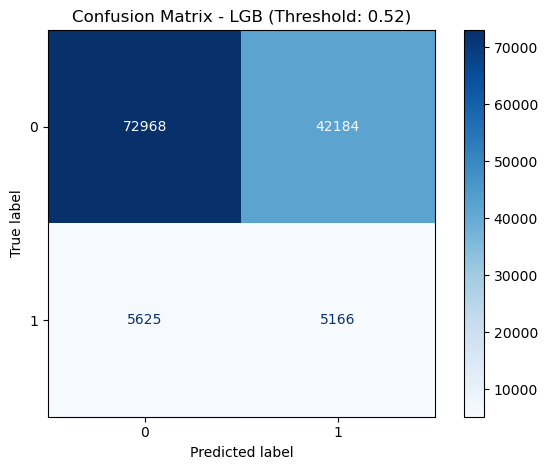

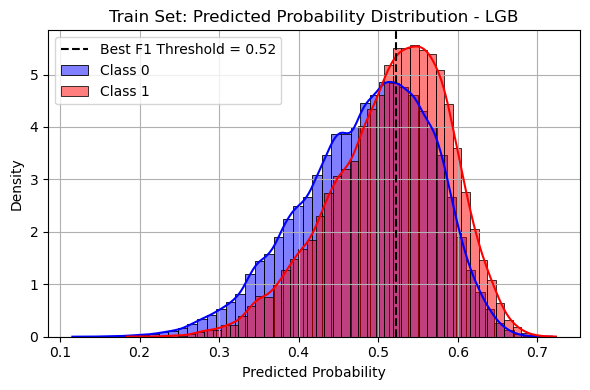

In [12]:
results_table = evaluate_model(lgb_model, "LGB", X_train, y_train, X_test, y_test, results_df=results_table)

In [13]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

# --- Calculate scale_pos_weight ---
pos = np.sum(y_train == 1)
neg = np.sum(y_train == 0)
scale_pos_weight = neg / pos

# --- Define tuned CatBoost model ---
catboost_model = CatBoostClassifier(
    iterations=150,
    learning_rate=0.05,          # ⬅️ slower learning
    depth=4,                     # ⬅️ reduced depth
    l2_leaf_reg=10,              # ⬅️ stronger regularization
    bagging_temperature=1.0,     # ⬅️ more randomness
    scale_pos_weight=scale_pos_weight,
    verbose=0,
    random_seed=42,
    eval_metric='AUC',
    thread_count=-1
)

# --- 5-Fold Cross-Validation (optional) ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_aucs, val_aucs = [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), 1):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    catboost_model.fit(X_tr, y_tr)
    y_tr_pred = catboost_model.predict_proba(X_tr)[:, 1]
    y_val_pred = catboost_model.predict_proba(X_val)[:, 1]

    tr_auc = roc_auc_score(y_tr, y_tr_pred)
    val_auc = roc_auc_score(y_val, y_val_pred)

    print(f"Fold {fold} - Train AUC: {tr_auc:.4f}, Validation AUC: {val_auc:.4f}")
    train_aucs.append(tr_auc)
    val_aucs.append(val_auc)

print("\nAverage Train AUC:", np.mean(train_aucs).round(4))
print("Average Validation AUC:", np.mean(val_aucs).round(4))


Fold 1 - Train AUC: 0.5935, Validation AUC: 0.5888
Fold 2 - Train AUC: 0.5942, Validation AUC: 0.5852
Fold 3 - Train AUC: 0.5936, Validation AUC: 0.5891
Fold 4 - Train AUC: 0.5935, Validation AUC: 0.5891
Fold 5 - Train AUC: 0.5946, Validation AUC: 0.5847

Average Train AUC: 0.5939
Average Validation AUC: 0.5874


y_train
False
y_trai_pred
False

✅ Evaluation for CatBoost
AUC - Train: 0.5925, Test: 0.5854
Best Accuracy Threshold: 0.67 | Train Acc: 0.9156, Test Acc: 0.9143
Best F1 Threshold: 0.52 | Precision: 0.1087, Recall: 0.5091, F1: 0.1792


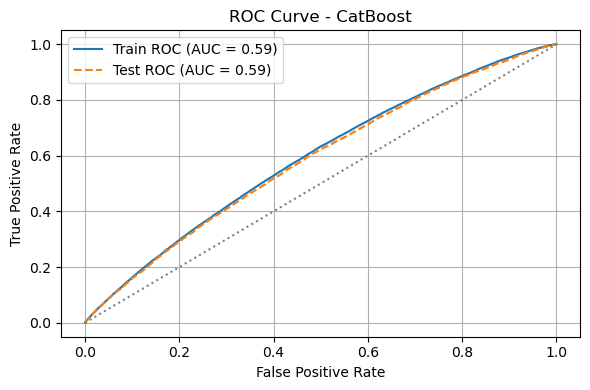

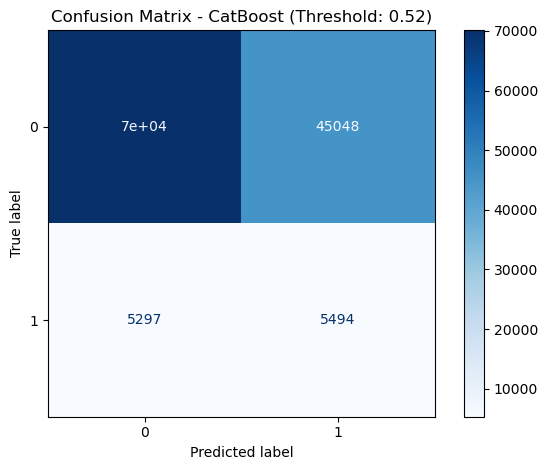

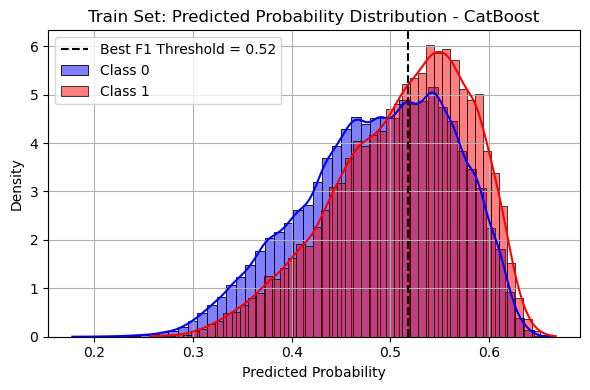

In [14]:
results_table = evaluate_model(catboost_model, "CatBoost", X_train, y_train, X_test, y_test, results_df=results_table)


📂 Fold 1
Epoch 1/200


/Users/tymoteusz/anaconda3/envs/stats_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1044/1044 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - auc: 0.5015 - loss: 0.5323 - val_auc: 0.5364 - val_loss: 0.2944 - learning_rate: 0.0010
Epoch 2/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - auc: 0.5139 - loss: 0.3030 - val_auc: 0.5694 - val_loss: 0.2892 - learning_rate: 0.0010
Epoch 3/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - auc: 0.5213 - loss: 0.2970 - val_auc: 0.5762 - val_loss: 0.2873 - learning_rate: 0.0010
Epoch 4/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - auc: 0.5404 - loss: 0.2920 - val_auc: 0.5793 - val_loss: 0.2867 - learning_rate: 0.0010
Epoch 5/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - auc: 0.5472 - loss: 0.2912 - val_auc: 0.5813 - val_loss: 0.2865 - learning_rate: 0.0010
Epoch 6/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - auc: 0.5539 - loss: 0.2896 - val_auc: 0.5838 - val_loss: 0.2862 - learning_rate: 0.0010
Epoch 7/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - auc: 0.5677 - loss: 0.2884 - val_auc: 0.5837 - val_loss: 0.2862 - learning_rate: 0.00

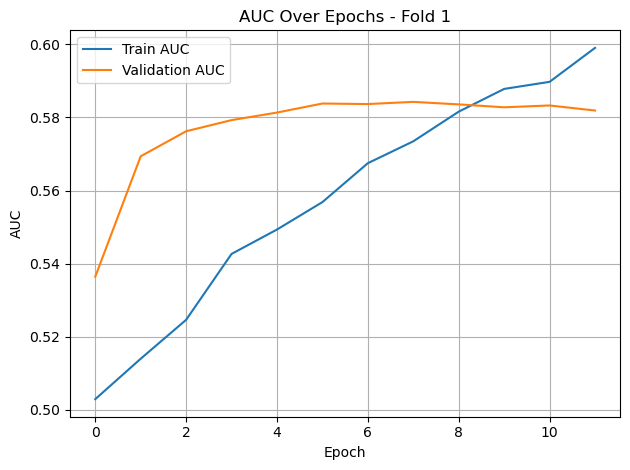


📂 Fold 2
Epoch 1/200


/Users/tymoteusz/anaconda3/envs/stats_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1044/1044 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - auc: 0.4999 - loss: 0.5394 - val_auc: 0.5195 - val_loss: 0.2946 - learning_rate: 0.0010
Epoch 2/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - auc: 0.5070 - loss: 0.3059 - val_auc: 0.5611 - val_loss: 0.2910 - learning_rate: 0.0010
Epoch 3/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - auc: 0.5210 - loss: 0.3010 - val_auc: 0.5737 - val_loss: 0.2875 - learning_rate: 0.0010
Epoch 4/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - auc: 0.5367 - loss: 0.2946 - val_auc: 0.5789 - val_loss: 0.2868 - learning_rate: 0.0010
Epoch 5/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - auc: 0.5469 - loss: 0.2924 - val_auc: 0.5794 - val_loss: 0.2864 - learning_rate: 0.0010
Epoch 6/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - auc: 0.5617 - loss: 0.2898 - val_auc: 0.5804 - val_loss: 0.2863 - learning_rate: 0.0010
Epoch 7/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - auc: 0.5702 - loss: 0.2868 - val_auc: 0.5810 - val_loss: 0.2862 - learning_rate: 0.00

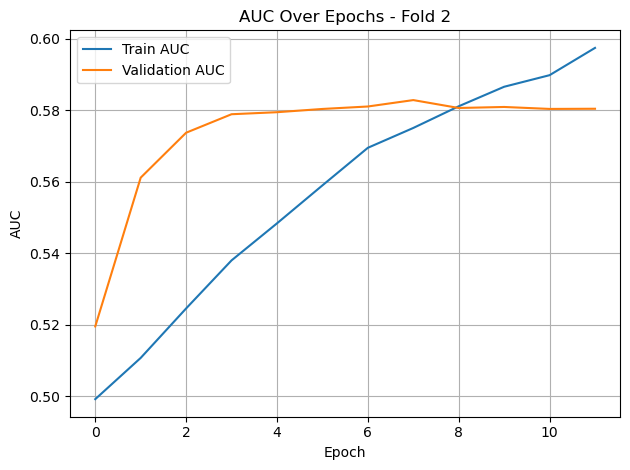


📂 Fold 3
Epoch 1/200


/Users/tymoteusz/anaconda3/envs/stats_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1044/1044 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - auc: 0.4986 - loss: 0.5258 - val_auc: 0.5256 - val_loss: 0.2920 - learning_rate: 0.0010
Epoch 2/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - auc: 0.5056 - loss: 0.3049 - val_auc: 0.5635 - val_loss: 0.2888 - learning_rate: 0.0010
Epoch 3/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - auc: 0.5155 - loss: 0.2989 - val_auc: 0.5767 - val_loss: 0.2873 - learning_rate: 0.0010
Epoch 4/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - auc: 0.5333 - loss: 0.2905 - val_auc: 0.5824 - val_loss: 0.2862 - learning_rate: 0.0010
Epoch 5/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - auc: 0.5488 - loss: 0.2904 - val_auc: 0.5840 - val_loss: 0.2861 - learning_rate: 0.0010
Epoch 6/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - auc: 0.5547 - loss: 0.2881 - val_auc: 0.5842 - val_loss: 0.2860 - learning_rate: 0.0010
Epoch 7/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - auc: 0.5681 - loss: 0.2878 - val_auc: 0.5826 - val_loss: 0.2861 - learning_rate: 0.00

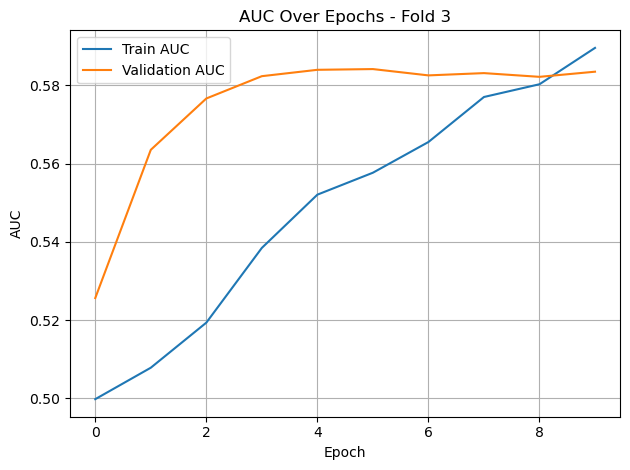


📂 Fold 4
Epoch 1/200


/Users/tymoteusz/anaconda3/envs/stats_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1044/1044 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - auc: 0.5021 - loss: 0.5509 - val_auc: 0.5011 - val_loss: 0.2951 - learning_rate: 0.0010
Epoch 2/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - auc: 0.5001 - loss: 0.3055 - val_auc: 0.5057 - val_loss: 0.2928 - learning_rate: 0.0010
Epoch 3/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - auc: 0.5090 - loss: 0.2988 - val_auc: 0.5519 - val_loss: 0.2898 - learning_rate: 0.0010
Epoch 4/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - auc: 0.5211 - loss: 0.2940 - val_auc: 0.5719 - val_loss: 0.2876 - learning_rate: 0.0010
Epoch 5/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - auc: 0.5426 - loss: 0.2911 - val_auc: 0.5792 - val_loss: 0.2866 - learning_rate: 0.0010
Epoch 6/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - auc: 0.5535 - loss: 0.2901 - val_auc: 0.5829 - val_loss: 0.2862 - learning_rate: 0.0010
Epoch 7/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - auc: 0.5627 - loss: 0.2913 - val_auc: 0.5849 - val_loss: 0.2860 - learning_rate: 0.00

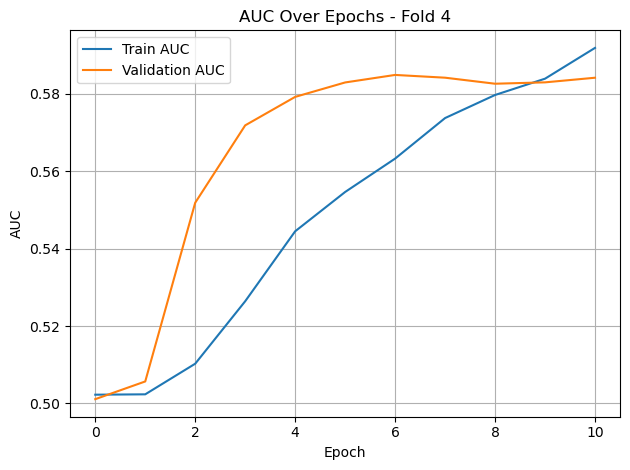


📂 Fold 5
Epoch 1/200


/Users/tymoteusz/anaconda3/envs/stats_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1044/1044 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - auc: 0.5015 - loss: 0.5321 - val_auc: 0.5141 - val_loss: 0.2943 - learning_rate: 0.0010
Epoch 2/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - auc: 0.5094 - loss: 0.3072 - val_auc: 0.5512 - val_loss: 0.2904 - learning_rate: 0.0010
Epoch 3/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - auc: 0.5212 - loss: 0.2969 - val_auc: 0.5714 - val_loss: 0.2882 - learning_rate: 0.0010
Epoch 4/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - auc: 0.5378 - loss: 0.2954 - val_auc: 0.5753 - val_loss: 0.2870 - learning_rate: 0.0010
Epoch 5/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - auc: 0.5505 - loss: 0.2876 - val_auc: 0.5774 - val_loss: 0.2867 - learning_rate: 0.0010
Epoch 6/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - auc: 0.5578 - loss: 0.2902 - val_auc: 0.5770 - val_loss: 0.2865 - learning_rate: 0.0010
Epoch 7/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - auc: 0.5660 - loss: 0.2862 - val_auc: 0.5794 - val_loss: 0.2864 - learning_rate: 0.00

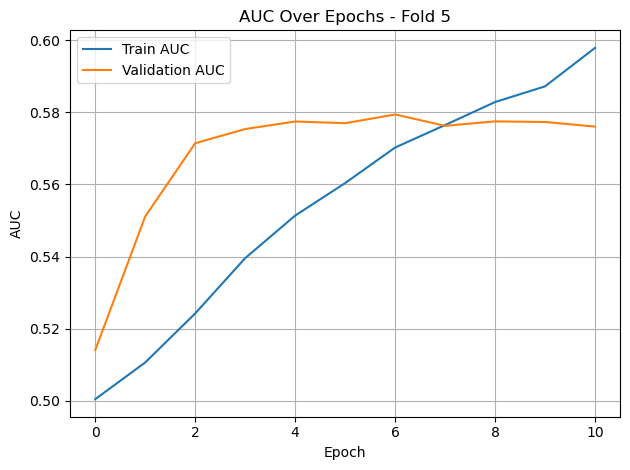


📊 Final Results:
Average Train AUC: 0.6015
Average Validation AUC: 0.5834

📦 Evaluating final NN model on full dataset


/Users/tymoteusz/anaconda3/envs/stats_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
1305/1305 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - auc: 0.4980 - loss: 0.5043 - val_auc: 0.5020 - val_loss: 0.2962 - learning_rate: 0.0010
Epoch 2/200
1305/1305 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - auc: 0.5012 - loss: 0.3021 - val_auc: 0.5276 - val_loss: 0.2936 - learning_rate: 0.0010
Epoch 3/200
1305/1305 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - auc: 0.5180 - loss: 0.2966 - val_auc: 0.5750 - val_loss: 0.2903 - learning_rate: 0.0010
Epoch 4/200
1305/1305 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - auc: 0.5419 - loss: 0.2915 - val_auc: 0.5791 - val_loss: 0.2897 - learning_rate: 0.0010
Epoch 5/200
1305/1305 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - auc: 0.5611 - loss: 0.2914 - val_auc: 0.5788 - val_loss: 0.2894 - learning_rate: 0.0010
Epoch 6/200
1305/1305 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - auc: 0.5623 - loss: 0.2907 - val_auc: 0.5798 - val_loss: 0.2895 - learning_rate: 0.0010
Epoch 7/200
1305/1305 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - auc: 0.5742 - loss: 0.2860 - val_auc: 0.5790 - val_loss: 0.2893 - learnin

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC

# === Define function to build model ===
def create_nn_model(input_dim):
    model = Sequential()
    model.add(Dense(256, activation='relu', input_dim=input_dim))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(16, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    # Custom Adam optimizer
    adam_optimizer = Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-7,
        amsgrad=False
    )

    model.compile(optimizer=adam_optimizer, 
                  loss='binary_crossentropy', 
                  metrics=[AUC(name='auc')])
    return model

# === 5-Fold Cross-Validation ===
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_aucs, val_aucs = [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), 1):
    print(f"\n📂 Fold {fold}")
    
    # Split
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Impute missing values
    imputer = SimpleImputer(strategy='mean')
    X_tr = pd.DataFrame(imputer.fit_transform(X_tr), columns=X_tr.columns)
    X_val = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)

    # Convert target dtype
    y_tr = y_tr.astype(np.float32).values
    y_val = y_val.astype(np.float32).values

    # Standardize features
    scaler = StandardScaler()
    X_tr_scaled = scaler.fit_transform(X_tr)
    X_val_scaled = scaler.transform(X_val)

    # Build and train model
    nn_model = create_nn_model(input_dim=X_tr_scaled.shape[1])
    history = nn_model.fit(
        X_tr_scaled, y_tr,
        validation_data=(X_val_scaled, y_val),
        epochs=200,
        batch_size=256,
        verbose=1,
        callbacks=[
            EarlyStopping(monitor='val_auc', mode='max', patience=4, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_auc', mode='max', factor=0.5, patience=3, min_lr=1e-5, verbose=1)
        ]
    )

    # Predict
    y_tr_pred = nn_model.predict(X_tr_scaled).flatten()
    y_val_pred = nn_model.predict(X_val_scaled).flatten()

    tr_auc = roc_auc_score(y_tr, y_tr_pred)
    val_auc = roc_auc_score(y_val, y_val_pred)

    print(f"✅ Fold {fold} - Train AUC: {tr_auc:.4f}, Validation AUC: {val_auc:.4f}")
    train_aucs.append(tr_auc)
    val_aucs.append(val_auc)

    # Plot AUC
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Validation AUC')
    plt.title(f"AUC Over Epochs - Fold {fold}")
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === Summary ===
print("\n📊 Final Results:")
print("Average Train AUC:", round(np.mean(train_aucs), 4))
print("Average Validation AUC:", round(np.mean(val_aucs), 4))


# --- Final model evaluation on full train/test ---
print("\n📦 Evaluating final NN model on full dataset")

# Impute and scale full datasets
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

y_train_array = y_train.astype(np.float32).values
y_test_array = y_test.astype(np.float32).values

# Train final model
final_nn_model = create_nn_model(input_dim=X_train_scaled.shape[1])
final_nn_model.fit(
    X_train_scaled, y_train_array,
    validation_data=(X_test_scaled, y_test_array),
    epochs=200,
    batch_size=256,
    verbose=1,
    callbacks=[
        EarlyStopping(monitor='val_auc', mode='max', patience=4, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_auc', mode='max', factor=0.5, patience=3, min_lr=1e-5, verbose=1)
    ]
)

In [ ]:
imputer = SimpleImputer(strategy='mean')
X_t = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_tes = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Convert target dtype
y_t = y_train.astype(np.float32).values
y_tes = y_test.astype(np.float32).values

# Standardize features
scaler = StandardScaler()
X_t = scaler.fit_transform(X_t)
X_tes = scaler.transform(X_tes)

NN
10440/10440 ━━━━━━━━━━━━━━━━━━━━ 3s 328us/step
3936/3936 ━━━━━━━━━━━━━━━━━━━━ 1s 326us/step
y_train
False
y_trai_pred
False

✅ Evaluation for NN_model
AUC - Train: 0.5953, Test: 0.5797
Best Accuracy Threshold: 0.30 | Train Acc: 0.9156, Test Acc: 0.9143
Best F1 Threshold: 0.09 | Precision: 0.1073, Recall: 0.5106, F1: 0.1774


/var/folders/zw/vcgtv4pj2zj7729jp71l9gvw0000gn/T/ipykernel_67252/3494301503.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, result_row], ignore_index=True)


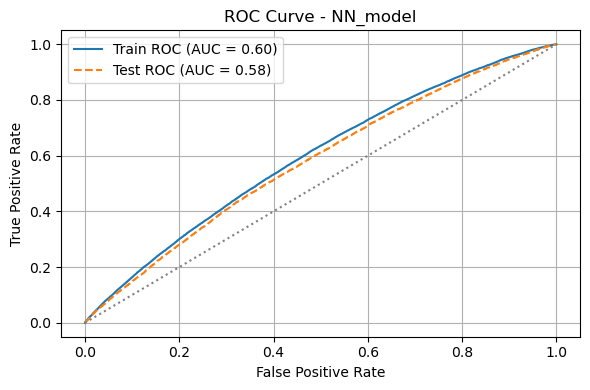

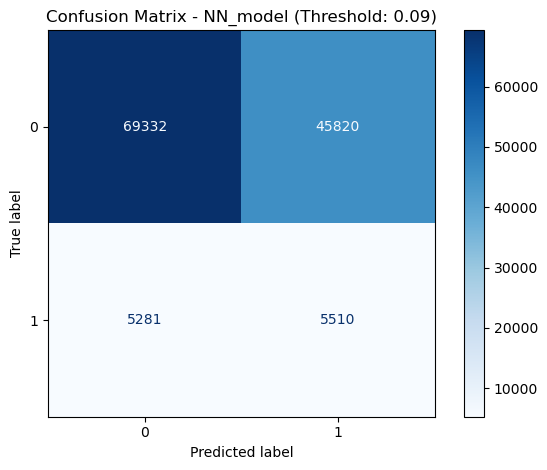

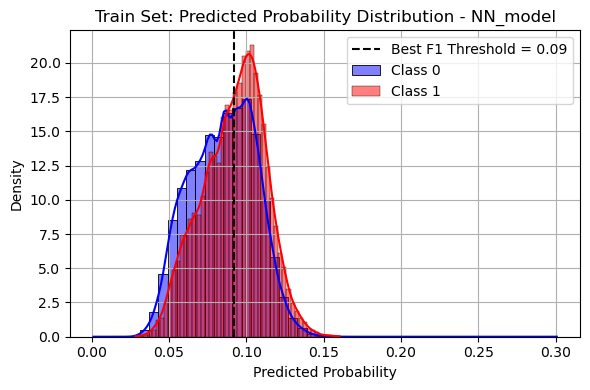

In [ ]:
results_table = evaluate_model(nn_model, "NN_model", X_t, y_t, X_tes, y_tes, results_df=results_table)

In [ ]:
results_table

,model_name,train_auc,test_auc,best_threshold_acc,train_accuracy,test_accuracy,best_threshold_f1,precision,sensitivity,f1_score
0,NN_model,0.5953,0.5797,0.3012,0.9156,0.9143,0.0924,0.1073,0.5106,0.1774
